In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

In [2]:
# label_folder = r'D:\Competitions\ComputerVision\OCR\Signalboard\dataset\train\label\custom'
# image_folder = r'D:\Competitions\ComputerVision\OCR\Signalboard\dataset\train\image\official'

label_folder = r'C:\Users\Atlas\Desktop\Sinalboard_OCR\dataset\train\label\custom'
image_folder = r'C:\Users\Atlas\Desktop\Sinalboard_OCR\dataset\train\image\official'

In [3]:
def get_patches_and_loc(category,ltwh,polygon,map_size):
    l,t,w,h = ltwh*map_size
    
    r = l+w
    cx = (l+r)/2
    
    b = t+h
    cy = (t+b)/2
    
    L = int(l)
    Cx = int(cx)
    T = int(t)
    R = int(r)
    Cy = int(cy)
    B = int(b)
    
    #create determine patch
    grid_center_coor = np.stack(np.broadcast_arrays((np.arange(L,R+1)+0.5),(np.arange(T,B+1)+0.5)[:,None]),axis=-1)/map_size
    grid_center_coor = grid_center_coor[:,:,None,:]
    bbox_rect_coor = np.array([[l,t],[r,t],[r,b],[l,b]])/map_size
    bbox_rect_coor = bbox_rect_coor[None,None,:,:]
    determine = np.max(np.abs(grid_center_coor-bbox_rect_coor)*2,axis=-1)
    determine = np.max(determine,axis=-1)
    
    #create center-ness patch
    horizon = np.concatenate([np.arange(L+1,Cx+1),np.array([cx]),np.arange(Cx+1,R+1)])
    horizon = np.fmin(horizon-l,r-horizon)/np.fmax(horizon-l,r-horizon)
    vertical = np.concatenate([np.arange(T+1,Cy+1),np.array([cy]),np.arange(Cy+1,B+1)])
    vertical = np.fmin(vertical-t,b-vertical)/np.fmax(vertical-t,b-vertical)
    centerness = np.sqrt(horizon*vertical[:,None])
    centerness = centerness[:,:,None]
    
    #create ground truth center patch
    gt_center = np.zeros_like(determine,dtype=float)
    gt_center[Cy-T,Cx-L] = 1.
    gt_center = gt_center[:,:,None]
    
    #create category patch
    category = np.full_like(determine,category,dtype=float)
    category = category[:,:,None]
    
    #create cxcywh patch
    cxcy = ltwh[:2] + ltwh[2:]/2
    wh = np.tile(ltwh[2:],(determine.shape[0],determine.shape[1],1))
    grid_center_coor = np.squeeze(grid_center_coor)
    cxcy_offset = cxcy - grid_center_coor
    cxcywh = np.concatenate([cxcy_offset,wh],axis=-1)
    
    #create polygon points offset patch
    rectangle = np.array([[l,t],[r,t],[r,b],[l,b]])/map_size
    polygon_points_offset = polygon - rectangle
    polygon_points_offset = polygon_points_offset.reshape(-1)
    polygon_points_offset = np.tile(polygon_points_offset,(determine.shape[0],determine.shape[1],1))
    
    label = np.concatenate([centerness,gt_center,category,cxcywh,polygon_points_offset],axis=-1)
    return L,R,T,B,determine,label

In [27]:
# label_id = 2908 #bbox最多
label_id = 5566
label_path = pathlib.Path(label_folder,f'img_{label_id}.json')
label = json.loads(label_path.read_text(encoding='utf8'))
image_byte = tf.io.read_file(pathlib.Path(image_folder,label['ImageName']).as_posix())
image = tf.image.decode_jpeg(image_byte)
image = tf.image.convert_image_dtype(image,tf.float32)
image = tf.image.resize(image,(1024,1024))

image_size = 1024
map_size = 128
determine_range = [16,32,64,128,256,512,1040]

determine_range = [(determine_range[i-1]+1,d) if i != 0 else (0,d) for i,d in enumerate(determine_range)]
determine_range = [(s/image_size,e/image_size) for s,e in determine_range]

categories = np.array([b['type'] for b in label['bboxes']])
rectangles_ltwh = np.array([b['rectangle']['ltwh'] for b in label['bboxes']])
rectangles_ltwh[:,2:] = rectangles_ltwh[:,2:]-1e-4
polygons_points =  np.array([b['polygon']['points'] for b in label['bboxes']])

# [layers_count,map_size,map_size,
# [
# center-ness,
# gt_center,
# category,
## the following features should be normalized by the vision field it belongs to
## four features for 
# rectangle_center_offset_x_coor,
# rectangle_center_offset_y_coor,
# rectange_width,
# rectangle_height,
# polygon_lt_to_rectangle_lt_offset_x_coor
# polygon_lt_to_rectangle_lt_offset_y_coor
# polygon_rt_to_rectangle_rt_offset_x_coor
# polygon_rt_to_rectangle_rt_offset_y_coor
# polygon_rb_to_rectangle_rb_offset_x_coor
# polygon_rb_to_rectangle_rb_offset_y_coor
# polygon_lb_to_rectangle_lb_offset_x_coor
# polygon_lb_to_rectangle_lb_offset_y_coor
# ]]
label_map = np.zeros([len(determine_range),map_size,map_size,1+1+1+4+4*2],dtype=float)


for category,ltwh,points in zip(categories,rectangles_ltwh,polygons_points):
    L,R,T,B,determine_patch,label_patch = get_patches_and_loc(category, ltwh, points, map_size)
    for i,dr in enumerate(determine_range):
        in_determine_range = (dr[0]<=determine_patch)&(determine_patch<=dr[1])
        greater_centerness = (label_patch[:,:,0]>label_map[i,T:B+1,L:R+1,0])
        mask = in_determine_range&greater_centerness
        mask = mask[:,:,None]
        label_map[i,T:B+1,L:R+1,:] = np.where(
            mask,
            label_patch,
            label_map[i,T:B+1,L:R+1,:])

=====0=====


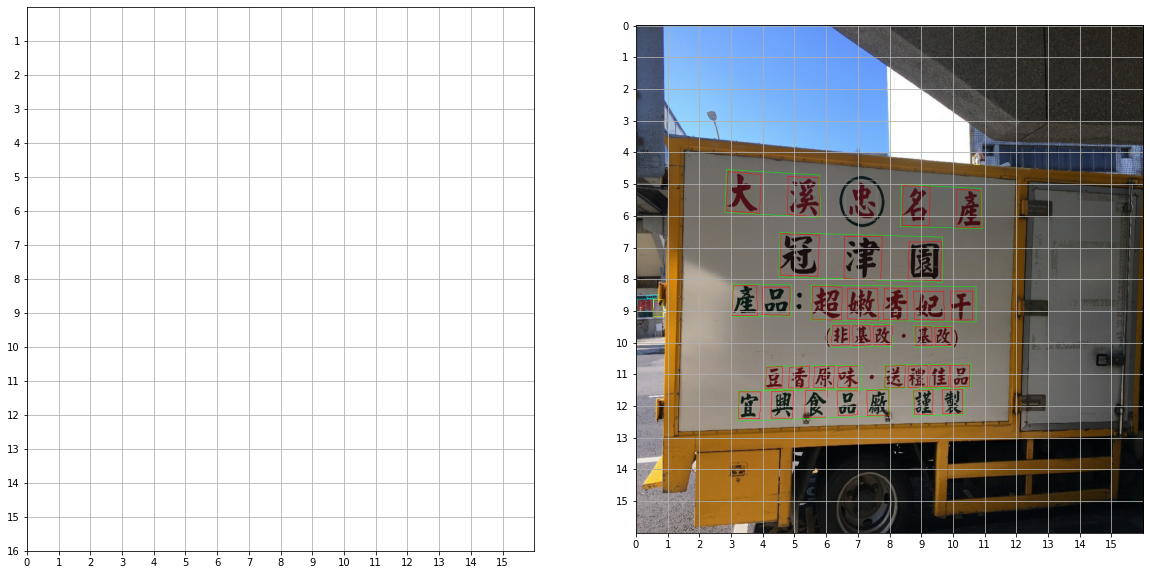

=====1=====


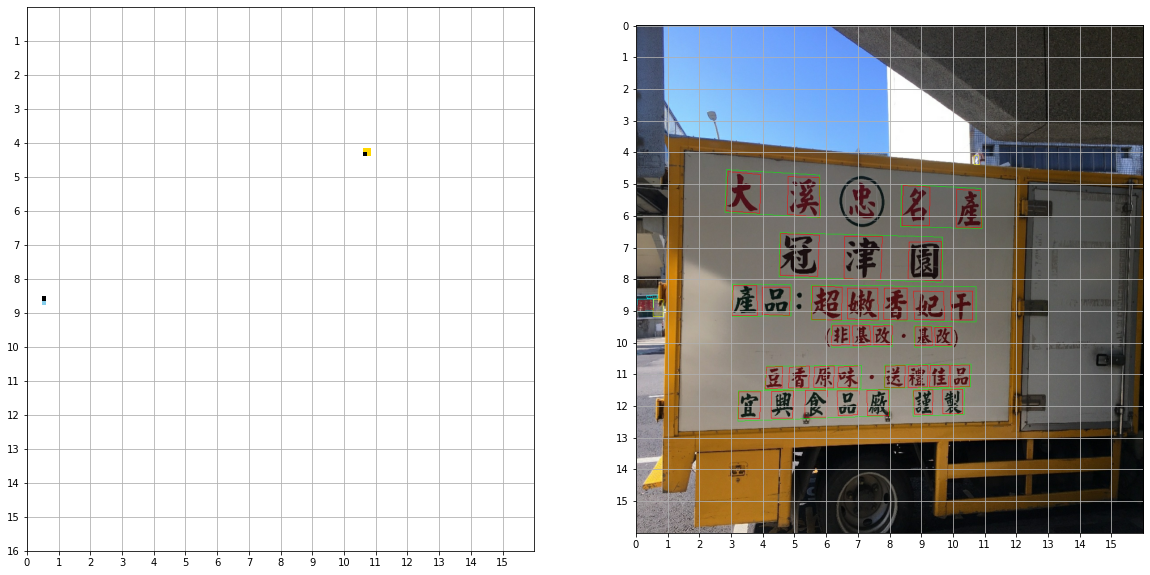

2


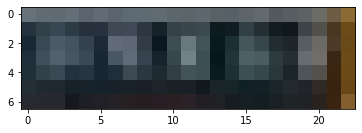

4


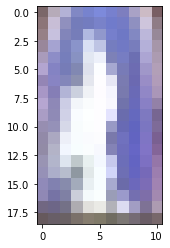

=====2=====


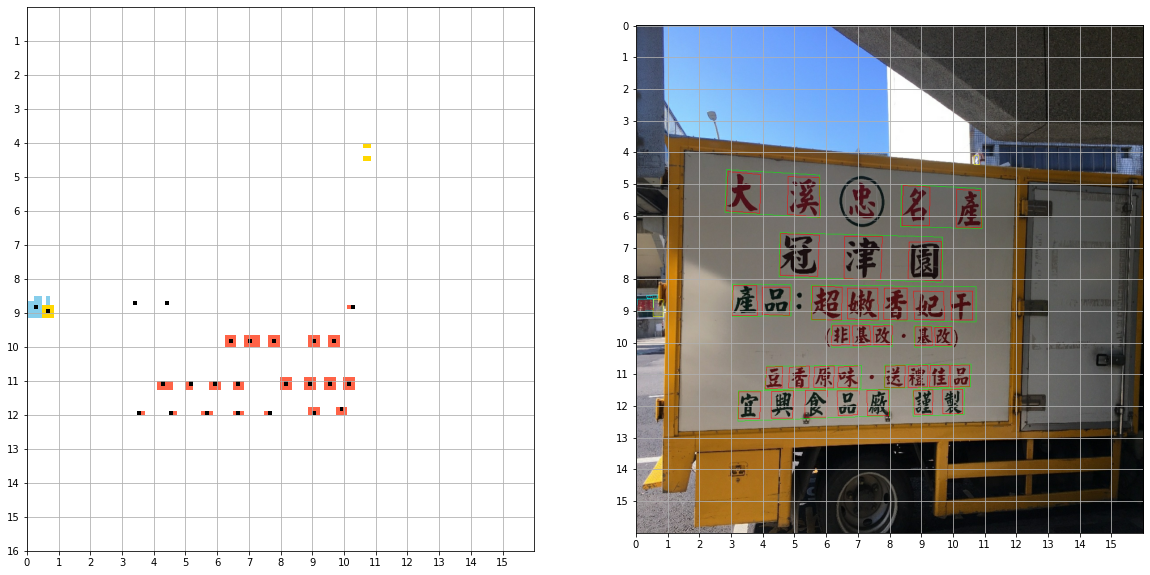

16


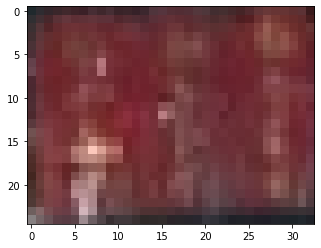

4


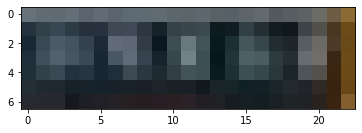

9


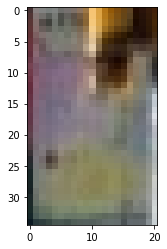

1


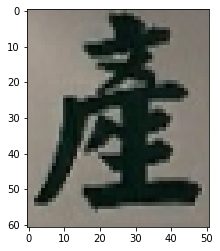

2


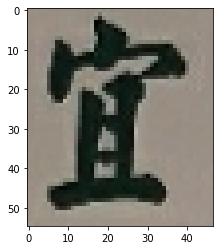

1


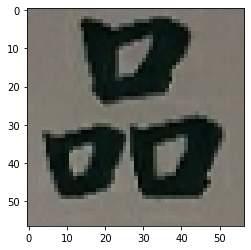

8


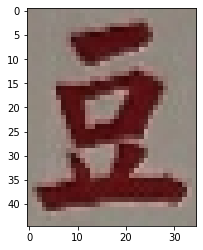

2


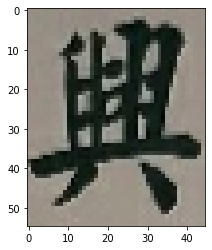

4


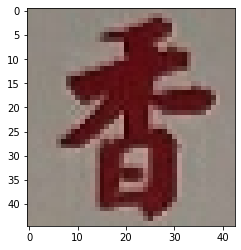

3


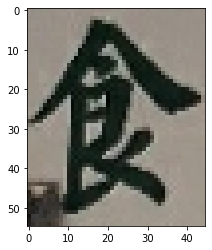

6


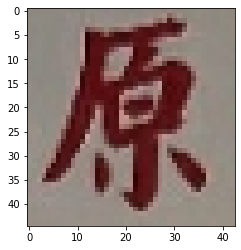

9


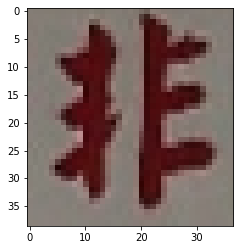

3


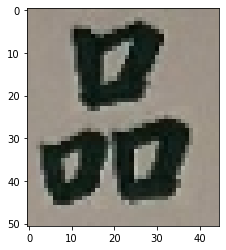

6


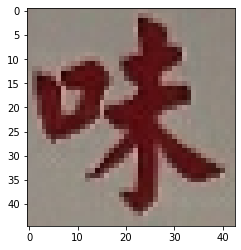

12


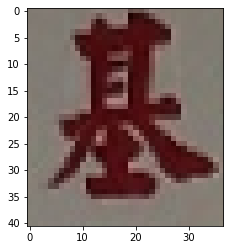

2


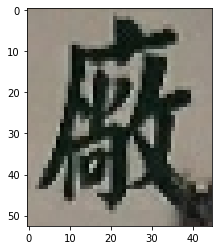

9


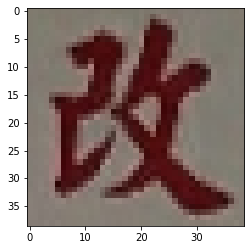

9


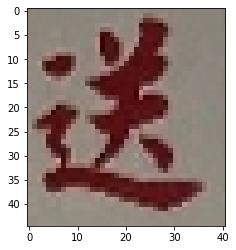

9


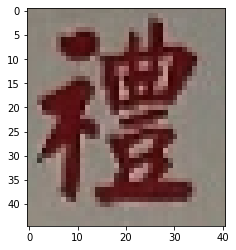

6


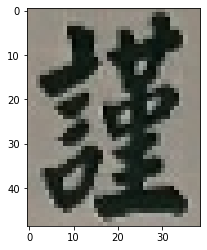

9


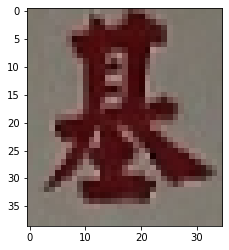

9


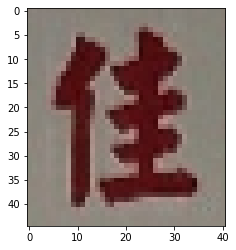

9


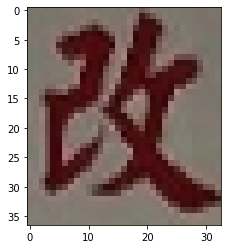

6


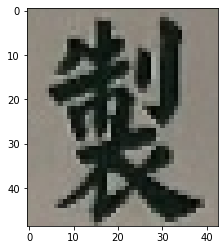

9


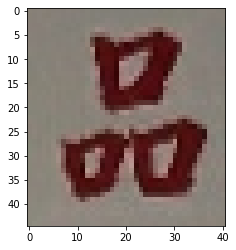

2


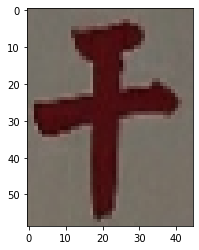

4


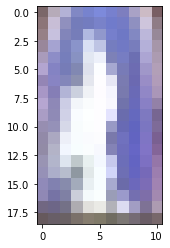

=====3=====


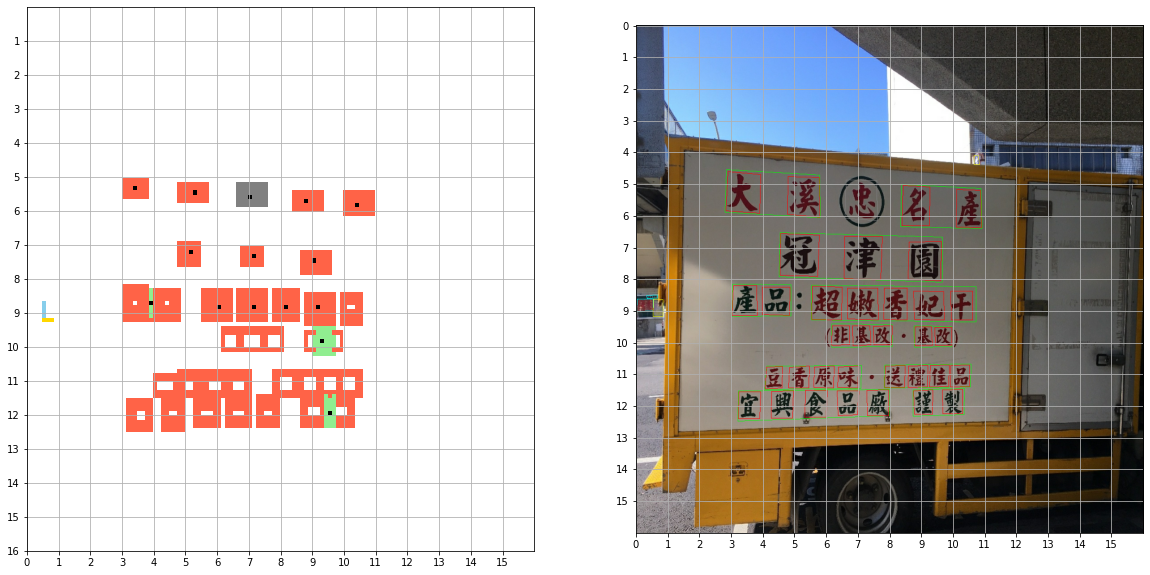

4


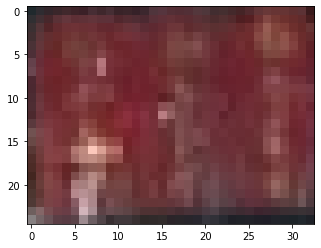

3


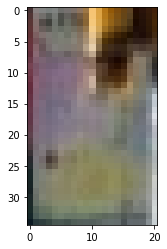

35


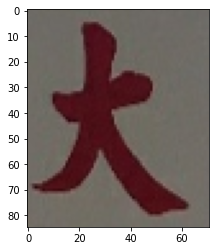

7


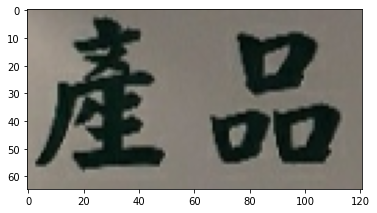

62


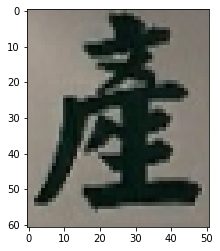

52


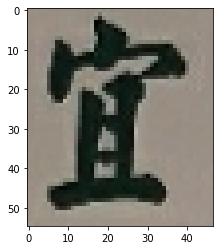

56


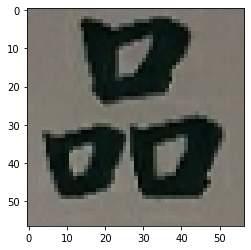

28


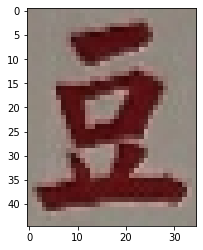

46


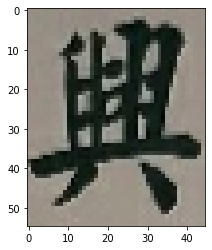

36


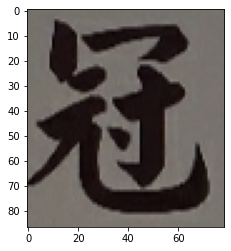

40


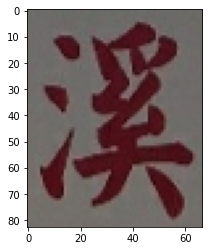

38


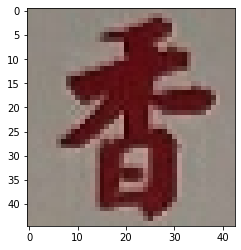

46


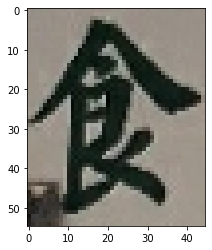

64


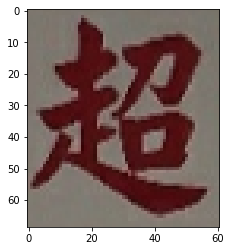

36


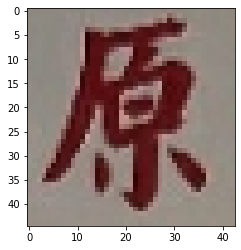

21


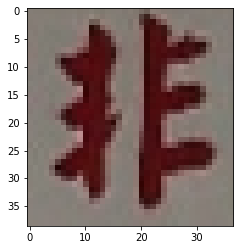

46


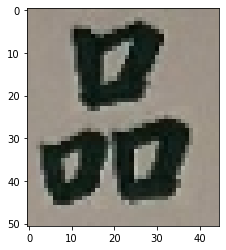

43


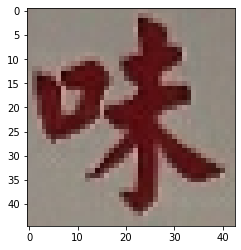

30


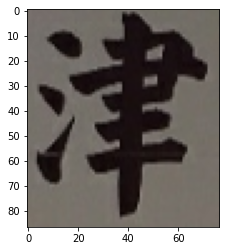

48


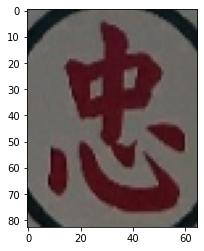

64


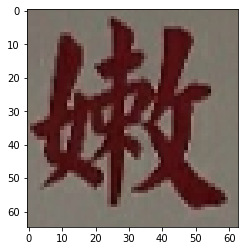

24


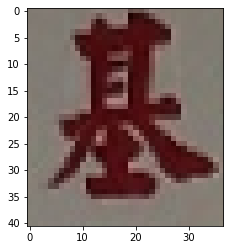

44


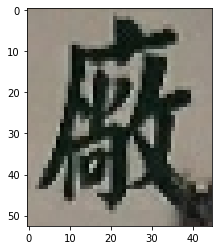

21


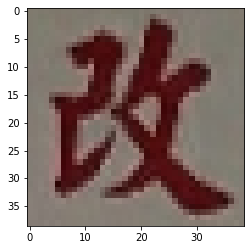

56


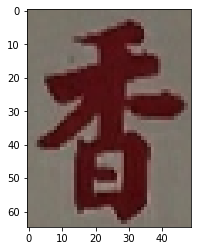

33


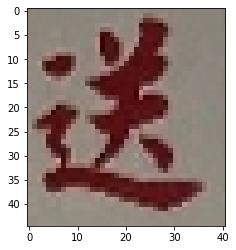

40


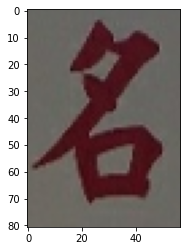

33


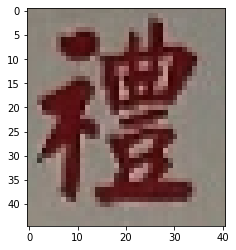

48


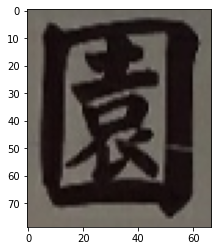

23


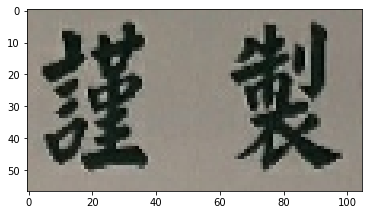

64


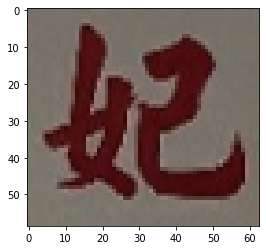

36


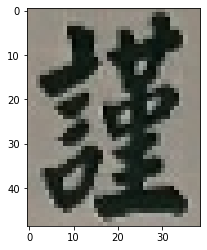

38


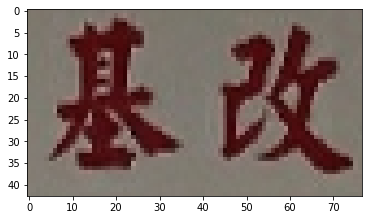

9


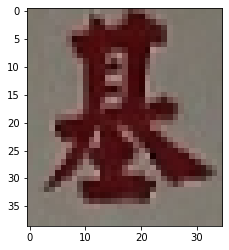

24


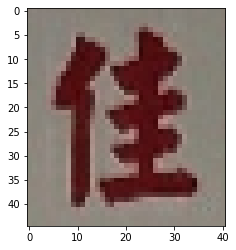

9


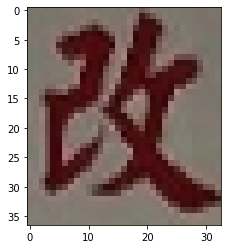

30


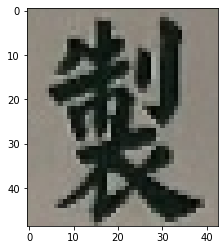

32


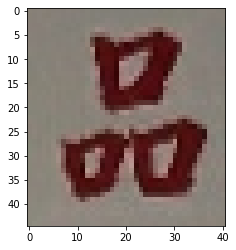

46


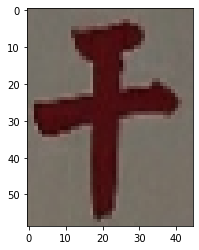

48


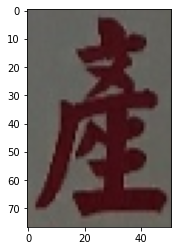

=====4=====


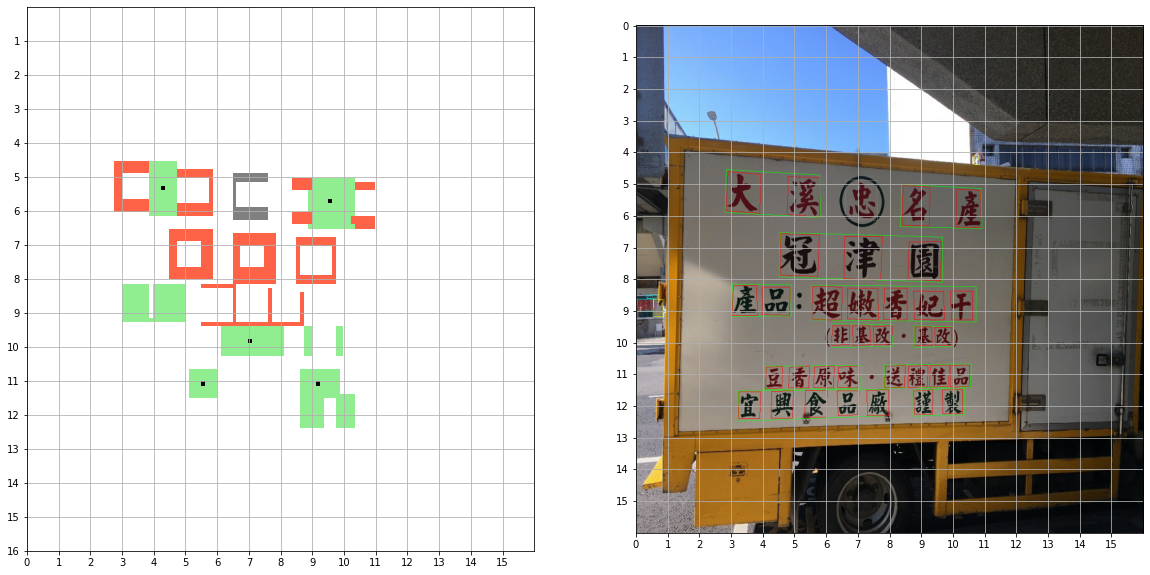

91


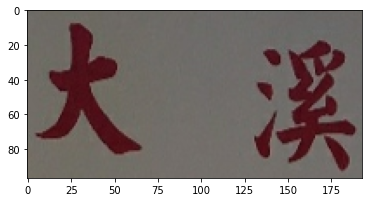

66


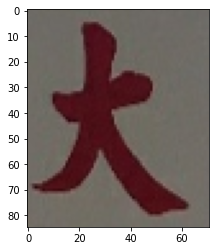

136


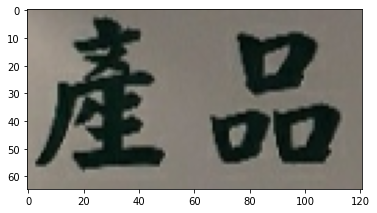

49


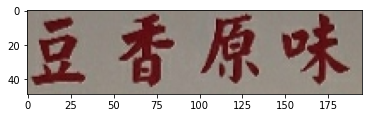

96


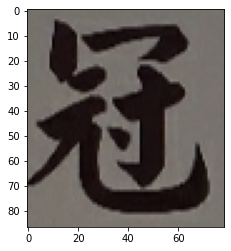

51


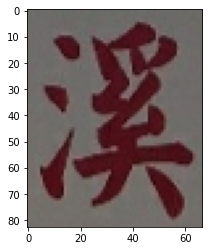

26


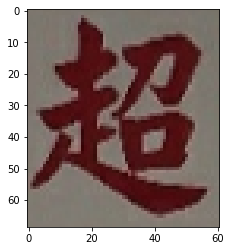

112


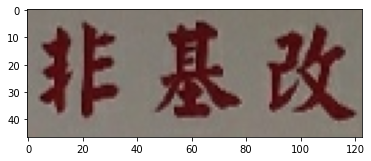

102


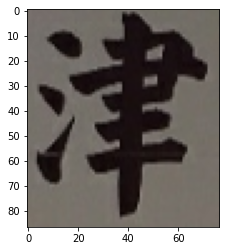

51


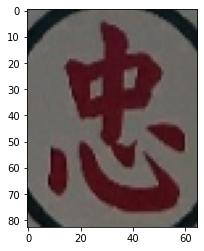

17


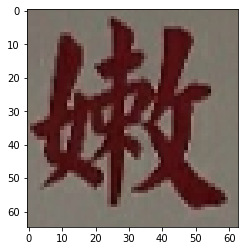

7


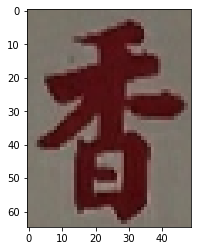

70


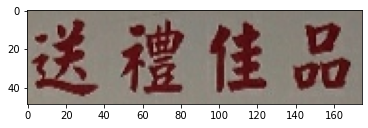

136


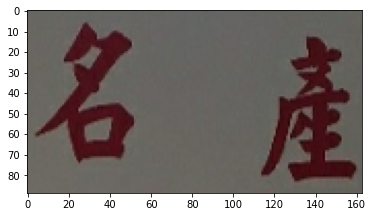

30


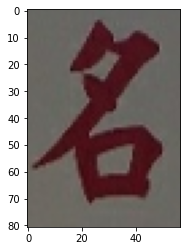

54


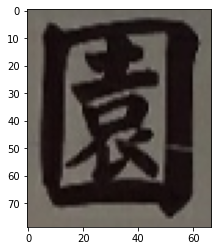

81


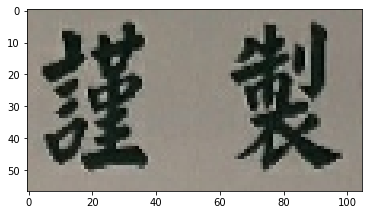

8


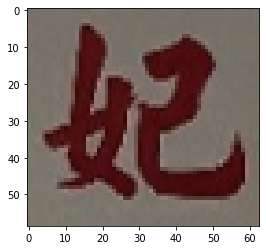

28


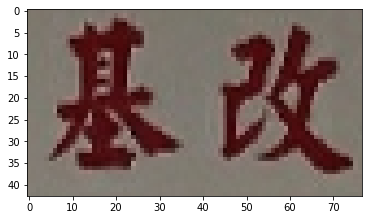

27


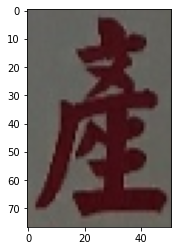

=====5=====


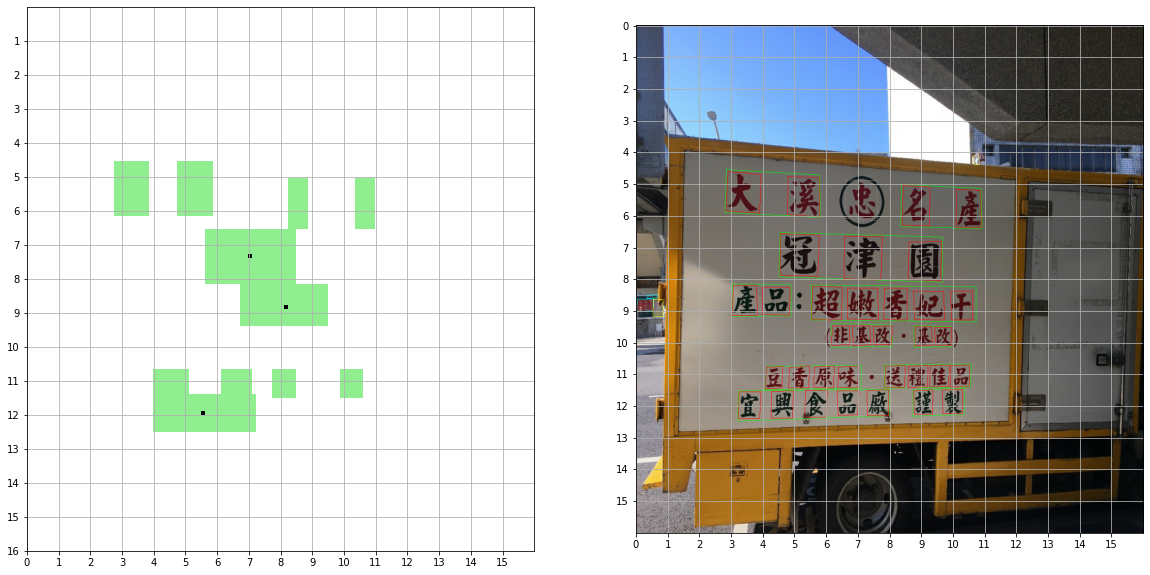

234


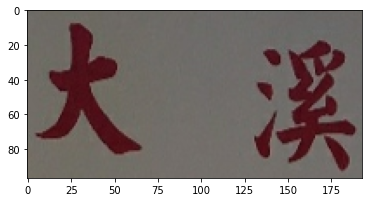

218


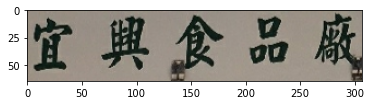

118


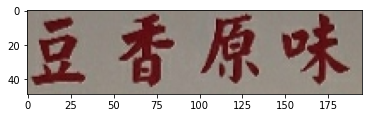

299


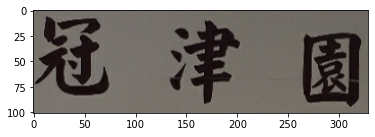

220


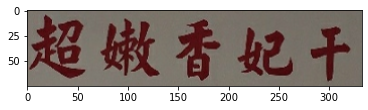

84


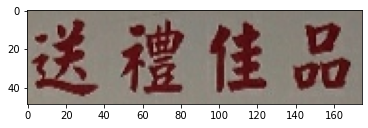

120


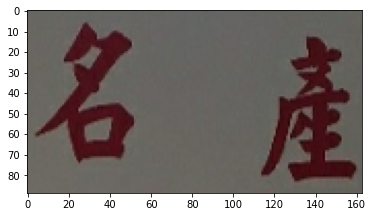

=====6=====


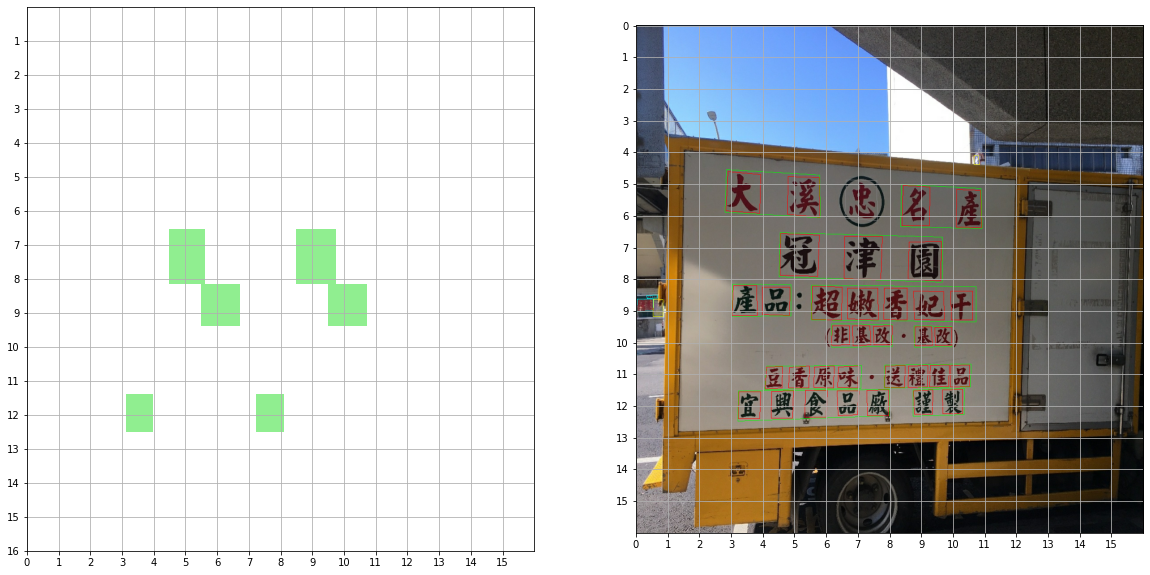

126


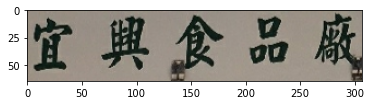

247


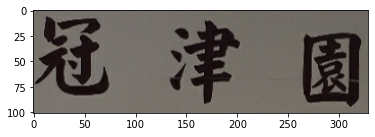

200


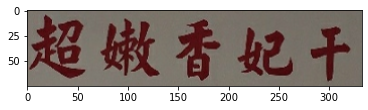

In [28]:
from matplotlib import colors

labeled_image = image.numpy()
style = {
    1:((1, 1, 0),1),
    2:((0, 1, 0),1),
    3:((1, 0, 0),1),
    4:((0.5, 0, 1),1),
    5:((1, 0, 1),1),
    6:((0.5, 0.5, 0.5),1),
    7:((0, 1, 1),1),
}
for bbox in label['bboxes']:
    b = (np.array(bbox['polygon']['points'])*1024).astype(int)
    color,lw = style[bbox['type']]
    cv2.polylines(labeled_image,[b],True,color,lw)

cmap = colors.ListedColormap(['white','gold','lightgreen','tomato','violet','hotpink','gray','skyblue','black'])
for i,c in enumerate(label_map[:,:,:,2]):
    print(f'====={i}=====')
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    c = c.copy()
    c[np.isclose(label_map[i,:,:,1],1)] = 8
    c = c[::-1]
    plt.pcolor(c,cmap=cmap,vmin=0, vmax=8)
    plt.xticks(np.arange(0,128,8),np.arange(0,16,1))
    plt.yticks(np.arange(0,128,8),np.arange(16,0,-1))
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.imshow(labeled_image)
    plt.xticks(np.arange(0,1024,64),np.arange(0,16,1))
    plt.yticks(np.arange(0,1024,64),np.arange(0,16,1))
    plt.grid()
    plt.show()
    
    obj_loc = np.where(~np.isclose(label_map[i,:,:,0],0))
    grid_center = np.stack(np.broadcast_arrays(np.arange(128),np.arange(128)[:,None]),axis=-1)+0.5
    grid_center = grid_center/128
    bbox_center = ((label_map[i,obj_loc[0],obj_loc[1],3:5] + grid_center[obj_loc[0],obj_loc[1]])*1024).astype(int)
    bbox_wh = (label_map[i,obj_loc[0],obj_loc[1],5:7]*1024).astype(int)

    for (l,t,r,b),count in zip(*np.unique(np.concatenate([bbox_center - bbox_wh//2,bbox_center + bbox_wh//2],axis=-1),axis=0,return_counts=True)):
        print(count)
        plt.imshow(image[t:b+1,l:r+1,:])
        plt.show()